In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import stats
from IPython.display import display, HTML
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from functions import pca_summary, printMeanAndSdByGroup, calclda, calcWithinGroupsVariance, groupStandardise, rpredict, calcBetweenGroupsVariance, calcSeparations

#https://colab.research.google.com/github/peterbmob/DHMVADoE/blob/main/Excercises/LDA_ex_2.ipynb 

# figures inline in notebook
%matplotlib inline

DISPLAY_MAX_ROWS = 20  # number of max rows to print for a DataFrame
pd.set_option('display.max_rows', DISPLAY_MAX_ROWS)

In [35]:
#Loading in the data
data = pd.read_csv('Concrete_Data.csv',sep=';')

#adjusting the names of the columns in the datatset
data.rename(columns={
    'Cement (component 1)(kg in a m^3 mixture)':'cement', 
    'Blast Furnace Slag (component 2)(kg in a m^3 mixture)':'blast_furnace_slag',
    'Fly Ash (component 3)(kg in a m^3 mixture)':'fly_ash', 
    'Water  (component 4)(kg in a m^3 mixture)':'water', 
    'Superplasticizer (component 5)(kg in a m^3 mixture)':'superplasticizer',
    'Coarse Aggregate  (component 6)(kg in a m^3 mixture)':'coarse_aggregate', 
    'Fine Aggregate (component 7)(kg in a m^3 mixture)':'fine_aggregate', 
    'Age (day)':'age', 
    'Concrete compressive strength(MPa, megapascals) ':'compressive_strength'
}, inplace=True)

data.head()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,compressive_strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [36]:
Y = data.compressive_strength #dependant variable
X = data.loc[:,:"age"] #independant variables

X

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360
...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28


In [37]:
compressive_str25 = 23.710
compressive_str50 = 34.445
compressive_str75 = 46.135
Y.describe().T


count    1030.000000
mean       35.817961
std        16.705742
min         2.330000
25%        23.710000
50%        34.445000
75%        46.135000
max        82.600000
Name: compressive_strength, dtype: float64

In [38]:
Y_labeled = []

for var in Y:  # Label the data according to compressive strength
    if var > compressive_str75:
        Y_labeled.append("Strong")
    elif compressive_str75 > var > compressive_str25:
        Y_labeled.append("Average")
    elif var < compressive_str25:
        Y_labeled.append("Weak")

Scaling the data

In [39]:
scaler = StandardScaler().fit(X) #Initialize a StandardScaler instance and fit it to the dataset X
standardisedX = scaler.transform(X) # Apply the scaler to the data (standardize the features in X) 
standardisedX = pd.DataFrame(standardisedX, columns=X.columns)#Convert the scaled data back into a dataframe of the same structure
standardisedX

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age
0,2.477915,-0.856888,-0.847144,-0.916764,-0.620448,0.863154,-1.217670,-0.279733
1,2.477915,-0.856888,-0.847144,-0.916764,-0.620448,1.056164,-1.217670,-0.279733
2,0.491425,0.795526,-0.847144,2.175461,-1.039143,-0.526517,-2.240917,3.553066
3,0.491425,0.795526,-0.847144,2.175461,-1.039143,-0.526517,-2.240917,5.057677
4,-0.790459,0.678408,-0.847144,0.488793,-1.039143,0.070527,0.647884,4.978487
...,...,...,...,...,...,...,...,...
1025,-0.045645,0.488235,0.564545,-0.092171,0.451410,-1.323005,-0.065893,-0.279733
1026,0.392819,-0.856888,0.960068,0.676200,0.702626,-1.994680,0.496893,-0.279733
1027,-1.270088,0.759579,0.850635,0.521589,-0.017528,-1.036064,0.080107,-0.279733
1028,-1.168610,1.308065,-0.847144,-0.279579,0.853356,0.214641,0.191166,-0.279733


PCA

In [40]:
pca = PCA().fit(standardisedX)
summary = pca_summary(pca, standardisedX)

Importance of components:


,sdev,varprop,cumprop
,Standard deviation,Proportion of Variance,Cumulative Proportion
PC1,1.510000,0.285012,0.285012
PC2,1.189989,0.177009,0.462022
PC3,1.157618,0.167510,0.629532
PC4,1.007055,0.126770,0.756302
PC5,0.975453,0.118938,0.875240
PC6,0.888929,0.098774,0.974014
PC7,0.421713,0.022230,0.996245
PC8,0.173329,0.003755,1.000000


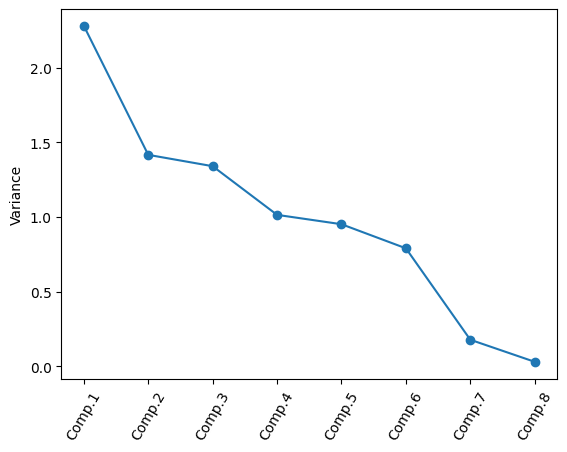

In [41]:
def screeplot(pca, standardised_values):
    y = np.std(pca.transform(standardised_values), axis=0)**2
    x = np.arange(len(y)) + 1
    plt.plot(x, y, "o-")
    plt.xticks(x, ["Comp."+str(i) for i in x], rotation=60)
    plt.ylabel("Variance")
    plt.show()

screeplot(pca, standardisedX)

### Loadings for the Principal Components

Positive: V1, V2, V4, V6 ,V8
Negative: V3, V5, V7

Principal component describe contrast between positive and negative components

Positive: V2, V4, V5
Negative: V1, V3, V6, V7, V8

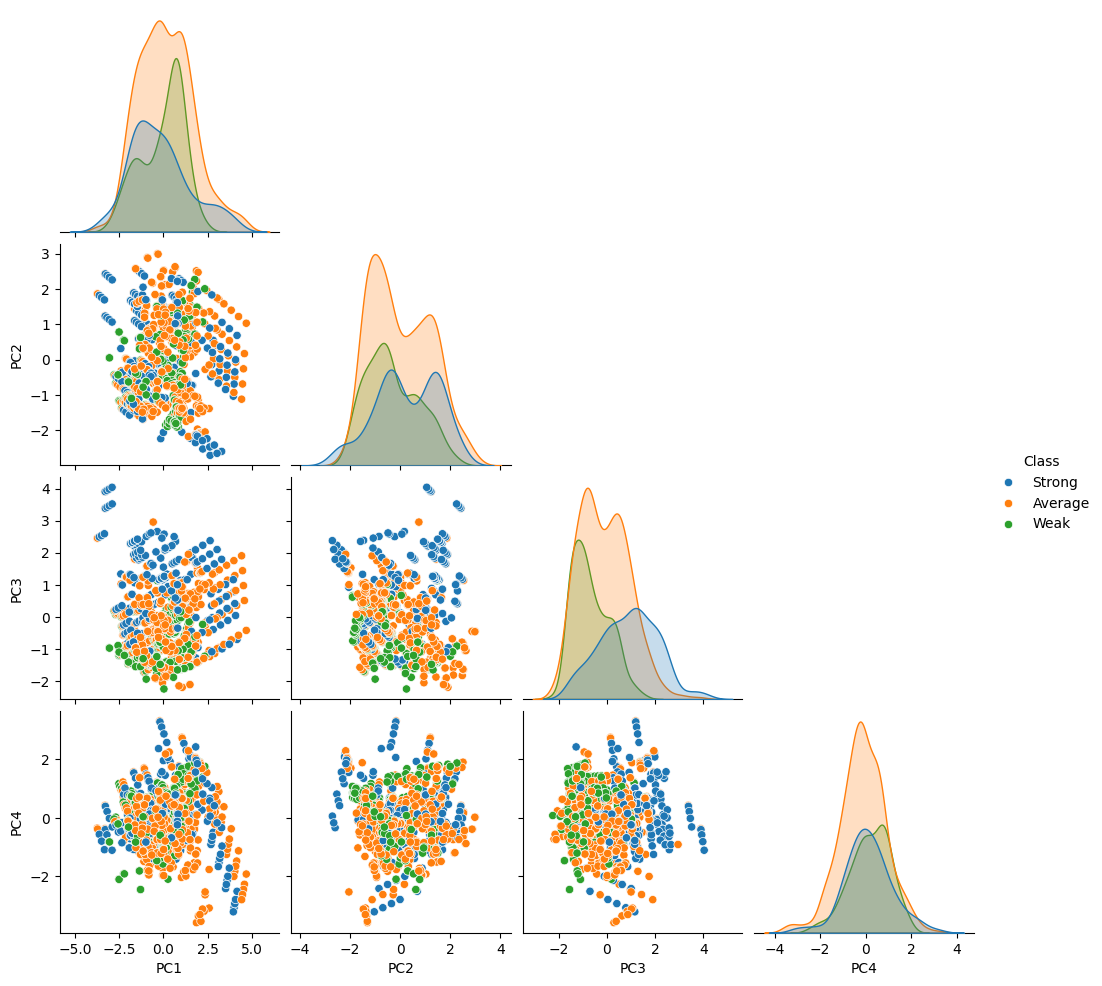

In [42]:
def pca_pairplot(pca, standardised_values, classifs):
    # Transform the standardized data using PCA
    foo = pca.transform(standardised_values)
    
    # Create a DataFrame with the first 4 principal components
    bar = pd.DataFrame({
        "PC1": foo[:, 0],
        "PC2": foo[:, 1],
        "PC3": foo[:, 2],
        "PC4": foo[:, 3],
        "Class": classifs
    })
    
    # Create a pairplot of the first 4 principal components with class as hue
    sns.pairplot(data=bar, vars=["PC1", "PC2", "PC3", "PC4"], hue="Class", diag_kind="kde", corner=True)
    
pca_pairplot(pca, standardisedX, Y_labeled)

In [43]:
pca.components_[0]

array([ 0.09840137,  0.17726197, -0.39466185,  0.54700395, -0.50594541,
        0.03792808, -0.40192597,  0.29147949])

Positive: V1, V2, V4, V6, V8 \
Negative: V3, V5, V7

In [44]:
pca.components_[1]

array([-0.11373709,  0.6860529 , -0.14294751,  0.05325628,  0.2829296 ,
       -0.62994342, -0.01939111, -0.12598089])

Positive: V2, V4, V5 \
Negative: V1, V3, V6, V7, V8

In [45]:
pca.components_[2]

array([ 0.81420224, -0.17179437, -0.40822055, -0.21318975,  0.23459653,
       -0.17408781, -0.00456921,  0.10052137])

Positive: V1, V5, V8 \
Negative: V2, V3, V4, V6, V7

In [46]:
pca.components_[3]

array([ 0.054297  ,  0.36269932, -0.2267512 , -0.29606003,  0.03727351,
        0.54580513, -0.38528206, -0.52791909])

Positive: V1, V2, V5, V6 \
Negative: V3, V4, V7, V8

In [47]:
printMeanAndSdByGroup(standardisedX, Y_labeled);

## Means:


,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age
Average,-0.072344,-0.000759,0.068315,0.157448,-0.076178,-0.085155,-0.058171,0.084849
Strong,0.689751,0.178351,-0.180722,-0.486653,0.545015,-0.157584,-0.172547,0.355506
Weak,-0.545624,-0.176838,0.044622,0.172978,-0.393250,0.327235,0.288437,-0.524547



## Standard deviations:


,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age
Average,0.935708,1.026321,0.980589,0.997680,0.893080,0.955511,1.025854,1.102344
Strong,0.980753,0.919373,0.921035,1.091784,1.130612,1.103781,1.060052,1.060216
Weak,0.715035,0.998318,1.093613,0.715235,0.819980,0.905575,0.814394,0.201575



## Sample sizes:


,0
Average,514
Strong,258
Weak,258


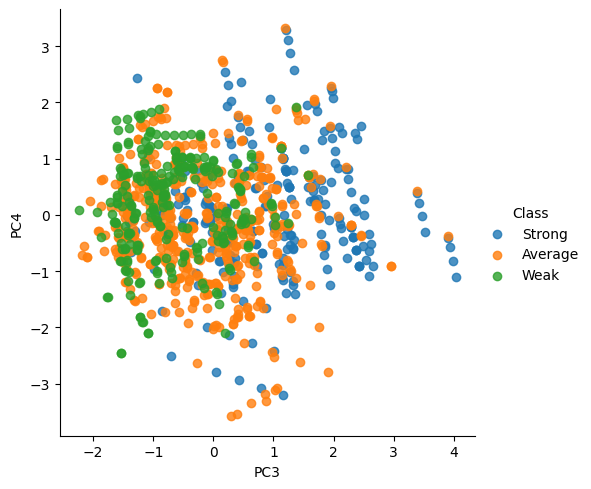

In [48]:
def pca_scatter(pca, standardised_values, classifs):
    foo = pca.transform(standardised_values)
    bar = pd.DataFrame(zip(foo[:, 2], foo[:, 3], classifs), columns=["PC3", "PC4", "Class"])
    sns.lmplot(data=bar, x="PC3", y="PC4", hue="Class", fit_reg=False)

pca_scatter(pca, standardisedX, Y_labeled)

## LDA

In [49]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis().fit(X, Y_labeled)

In [50]:
def pretty_scalings(lda, X, out=False):
    ret = pd.DataFrame(lda.scalings_, index=X.columns, columns=["LD"+str(i+1) for i in range(lda.scalings_.shape[1])])
    if out:
        print("Coefficients of linear discriminants:")
        display(ret)
    return ret

pretty_scalings_ = pretty_scalings(lda, X, out=True)

Coefficients of linear discriminants:


,LD1,LD2
cement,0.012837,0.002125
blast_furnace_slag,0.011205,0.001880
fly_ash,0.009758,-0.006267
water,-0.012967,-0.012794
superplasticizer,0.040280,0.033831
coarse_aggregate,0.001867,0.007862
fine_aggregate,0.002190,0.004307
age,0.012485,-0.006836


In [51]:
lda.scalings_[:, 0]

array([ 0.01283694,  0.01120492,  0.00975847, -0.01296746,  0.04028029,
        0.00186699,  0.00219017,  0.01248492])

In [52]:
pretty_scalings_.LD1

cement                0.012837
blast_furnace_slag    0.011205
fly_ash               0.009758
water                -0.012967
superplasticizer      0.040280
coarse_aggregate      0.001867
fine_aggregate        0.002190
age                   0.012485
Name: LD1, dtype: float64

In [53]:
calclda(X, lda.scalings_[:, 0])

array([ 1.76134601,  1.78935085,  2.37794879, ..., -0.94346348,
       -0.70500425, -0.3264935 ])

In [54]:
lda.fit_transform(X, Y_labeled)[:, 0]

array([ 1.76134601,  1.78935085,  2.37794879, ..., -0.94346348,
       -0.70500425, -0.3264935 ])

## Group stanardised LDA

In [55]:
groupstandardisedX = groupStandardise(X, Y)

In [56]:
lda2 = LinearDiscriminantAnalysis().fit(groupstandardisedX, Y_labeled)
pretty_scalings(lda2, groupstandardisedX)

,LD1,LD2
cement,-0.793692,-0.131409
blast_furnace_slag,-0.666839,-0.111865
fly_ash,-0.325951,0.209324
water,0.195217,0.192606
superplasticizer,-0.141179,-0.118576
coarse_aggregate,-0.095788,-0.403355
fine_aggregate,-0.125078,-0.245943
age,-0.699189,0.382849


## Separation achieved by the Discriminant functions

In [57]:
lda_values = rpredict(lda, standardisedX, Y_labeled, True)

class
['Weak' 'Weak' 'Weak' ... 'Weak' 'Weak' 'Weak']

posterior
       Average        Strong      Weak
0     0.038625  3.898182e-09  0.961375
1     0.038617  3.901907e-09  0.961383
2     0.039233  3.688575e-09  0.960767
3     0.040311  3.885864e-09  0.959689
4     0.040204  3.997005e-09  0.959796
...        ...           ...       ...
1025  0.039896  4.203972e-09  0.960104
1026  0.039773  4.142100e-09  0.960227
1027  0.038604  3.810027e-09  0.961396
1028  0.039416  4.235433e-09  0.960584
1029  0.039145  3.970366e-09  0.960855

[1030 rows x 3 columns]

x
           LD1       LD2
0    -1.761346 -1.103696
1    -1.789351 -1.221623
2    -2.377949  2.855034
3    -3.564016  3.504479
4    -2.730036  1.951525
...        ...       ...
1025 -0.473006  0.751277
1026  0.142869  1.405760
1027  0.943463  1.130437
1028  0.705004 -0.858772
1029  0.326493  1.090288

[1030 rows x 2 columns]


In [58]:
calcSeparations(lda_values["x"], Y)

variable LD1 Vw= 0.4950408102213417 Vb= 2.321405799203974 separation= 4.689322074610438
variable LD2 Vw= 0.5771470718949989 Vb= 1.1445626145497823 separation= 1.9831385625707791


In [59]:
def proportion_of_trace(lda):
    ret = pd.DataFrame([round(i, 4) for i in lda.explained_variance_ratio_ if round(i, 4) > 0], columns=["ExplainedVariance"])
    ret.index = ["LD"+str(i+1) for i in range(ret.shape[0])]
    ret = ret.transpose()
    print("Proportion of trace:")
    print(ret.to_string(index=False))
    return ret

proportion_of_trace(LinearDiscriminantAnalysis(solver="eigen").fit(X, Y_labeled));

Proportion of trace:
   LD1    LD2
0.9572 0.0428


In [60]:
def ldahist(data, g, sep=False):
    xmin = np.trunc(np.min(data)) - 1
    xmax = np.trunc(np.max(data)) + 1
    ncol = len(set(g))
    binwidth = 0.5
    bins=np.arange(xmin, xmax + binwidth, binwidth)
    if sep:
        fig, axl = plt.subplots(ncol, 1, sharey=True, sharex=True)
    else:
        fig, axl = plt.subplots(1, 1, sharey=True, sharex=True)
        axl = [axl]*ncol
    for ax, (group, gdata) in zip(axl, data.groupby(g)):
        sns.histplot(gdata.values, bins=10, ax=ax, label="group "+str(group),stat="density", kde=True,kde_kws=dict(cut=1),alpha=.4, edgecolor=(1, 1, 1, .4))
        ax.set_xlim([xmin, xmax])
        if sep:
            ax.set_xlabel("group"+str(group))
        else:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()

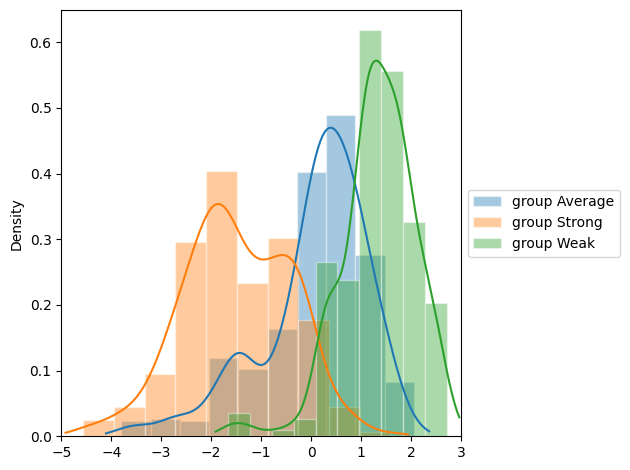

In [61]:
ldahist(lda_values["x"].LD1, Y_labeled)

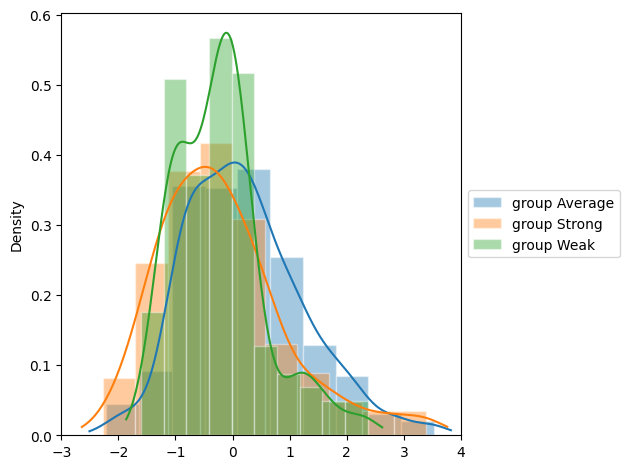

In [62]:
ldahist(lda_values["x"].LD2, Y_labeled)

In [63]:
#TODO extend to more groups, look at the PCA components
# all functions in callable file

In [64]:
Y_labeled = []
for var in Y:  # Label the data according to compressive strength
    if var > compressive_str50:
        Y_labeled.append("Strong")
    elif var < compressive_str50:
        Y_labeled.append("Weak")

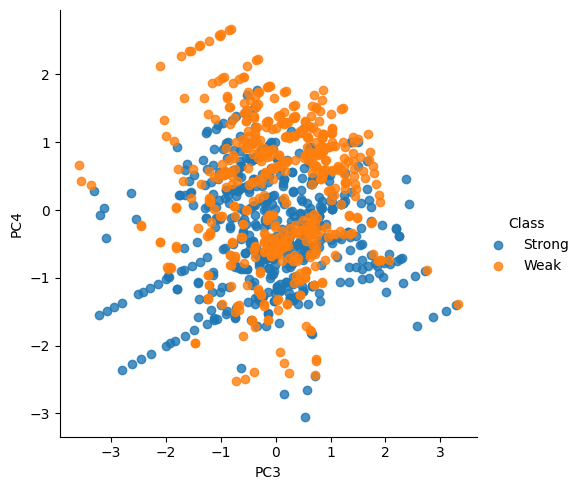

In [65]:
def pca_scatter(pca, standardised_values, classifs):
    foo = pca.transform(standardised_values)
    bar = pd.DataFrame(zip(foo[:, 3], foo[:, 4], classifs), columns=["PC3", "PC4", "Class"])
    sns.lmplot(data=bar, x="PC3", y="PC4", hue="Class", fit_reg=False)

pca_scatter(pca, standardisedX, Y_labeled)

In [66]:
lda = LDA().fit(standardisedX, Y_labeled)
lda_values=rpredict(lda, standardisedX, Y_labeled, True)

class
['Strong' 'Strong' 'Strong' ... 'Weak' 'Weak' 'Weak']

posterior
        Strong      Weak
0     0.956128  0.043872
1     0.956724  0.043276
2     0.990984  0.009016
3     0.999006  0.000994
4     0.994918  0.005082
...        ...       ...
1025  0.648229  0.351771
1026  0.432883  0.567117
1027  0.159291  0.840709
1028  0.208238  0.791762
1029  0.338248  0.661752

[1030 rows x 2 columns]

x
           LD1
0    -1.778208
1    -1.786456
2    -2.711879
3    -3.988709
4    -3.044968
...        ...
1025 -0.352723
1026  0.155857
1027  0.959908
1028  0.770677
1029  0.387255

[1030 rows x 1 columns]


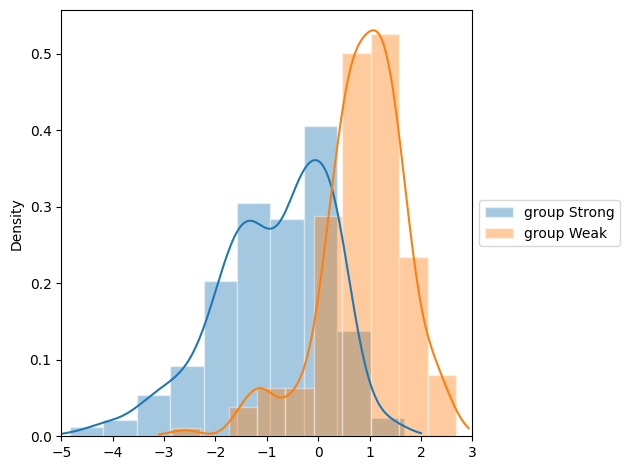

In [67]:
ldahist(lda_values["x"].LD1, Y_labeled)